In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
from config.config import LSTM_DATA_DIR, LSTM_MODELS_DIR, LSTM_CALIBRATED_DIR, SWAT_PREDICTIONS_DIR
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import keras_tuner as kt
import joblib
from tensorflow.keras.layers import Dropout


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
swat_df_predictions = pd.read_csv(os.path.join(SWAT_PREDICTIONS_DIR, 'swat_predictions.csv'))
swat_df_predictions['datetime'] = pd.to_datetime(swat_df_predictions['datetime'])
swat_df_predictions = swat_df_predictions.set_index('datetime')

swat_df_predictions

,a01,a03,a04,a05,a07,a08,a09,a11,a12,a13,...,a62,a65,a66,a67,a68,a69,a70,a71,a72,a73
datetime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,5.026,0.14340,2.823,0.5048,4.993,0.6552,0.0,21.120,22.030,0.1463,...,1.0870,0.05989,0.4232,0.10740,2.256,1.6240,0.00000,0.479200,6.5790,0.4671
2001-01-02,5.287,0.13700,2.780,0.5047,5.393,0.5864,0.0,22.700,23.570,0.1443,...,0.9923,0.05472,0.4108,0.10020,3.286,1.6020,0.00000,0.454400,5.9960,0.4589
2001-01-03,4.684,0.12980,2.738,0.5049,4.654,0.5806,0.0,19.930,20.670,0.1410,...,0.9070,0.05137,0.3747,0.09423,2.234,1.5860,0.00000,0.430700,5.6950,0.4535
2001-01-04,4.572,0.12290,2.706,0.5046,4.542,0.5801,0.0,19.280,20.040,0.1435,...,0.8359,0.04723,0.3800,0.08933,9.433,1.5720,0.00000,0.409300,5.7410,0.4666
2001-01-05,4.388,0.11610,2.663,0.5048,4.365,0.5838,0.0,18.330,19.050,0.1408,...,0.8483,0.04423,0.3385,0.08329,5.597,1.5580,0.00000,0.386800,5.7620,0.4801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.161,0.06489,1.983,NaN,1.120,NaN,0.0,5.160,4.784,0.1321,...,0.0000,0.05847,0.1901,0.19130,3.134,0.8721,0.00000,0.001752,1.2920,0.0000
2021-12-28,1.156,0.06115,1.972,NaN,1.115,NaN,0.0,2.377,1.944,0.1325,...,0.0000,0.05527,0.1925,0.18940,3.165,0.8681,0.00419,0.000000,1.2280,0.0000
2021-12-29,1.145,0.05573,1.974,NaN,1.104,NaN,0.0,2.410,2.018,0.1321,...,0.0000,0.04724,0.1883,0.18580,3.086,0.8546,0.00000,0.000000,1.1070,0.0000


In [5]:
merged_train_all_stations = []
merged_val_all_stations = []
merged_test_all_stations = []

n_input = 150
n_features = 18
#n_features = 3

train_normalization_features = []

#get all the files in the directory
files = os.listdir(LSTM_DATA_DIR)

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(LSTM_DATA_DIR / file))

        station_name = file.replace('_stats.csv', '')

        df_swat = swat_df_predictions[[station_name]].copy()


        #convert datetime to timestamp and make it the index
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

        
        #merge with SWAT predictions on index
        df = df.merge(df_swat, how='left', left_index=True, right_index=True)

        df  = df.drop(columns = ['Flow'])

        #split between tain, validation and test
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.85)]
        test_df = df[int(n*0.85):]


        #Create the generator
        #X_train = train_df.values
        #X_train = train_df[['Flow', 'precipitation', 'temperature']].values
        X_train = train_df.drop(columns=[station_name]).values
        y_train = train_df[station_name].values
        
        #X_val = val_df.values
        #X_val = val_df[['Flow', 'precipitation', 'temperature']].values
        X_val = val_df.drop(columns=[station_name]).values
        y_val = val_df[station_name].values


        #X_test = test_df.values
        #X_test = test_df[['Flow', 'precipitation', 'temperature']].values
        X_test = test_df.drop(columns=[station_name]).values
        y_test = test_df[station_name].values

        #store data for normalization
        train_normalization_features.extend(X_train)

        train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=1)
        val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=1)
        test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=1)


        #Get [([info day 1, ..., info day n], flow observation)]
        merged_train = [(sample[0][0], sample[1][0]) for sample in train_generator]
        merged_val = [(sample[0][0], sample[1][0]) for sample in val_generator]
        merged_test = [(sample[0][0], sample[1][0]) for sample in test_generator]


        merged_train_all_stations.extend(merged_train)
        merged_val_all_stations.extend(merged_val)
        merged_test_all_stations.extend(merged_test)


In [6]:
scaler = StandardScaler()
scaler.fit(train_normalization_features)

StandardScaler()

In [7]:
#shuffle the data
#np.random.shuffle(merged_train_all_stations)
#np.random.shuffle(merged_val_all_stations)

X_train, y_train = zip(*merged_train_all_stations)
X_val, y_val = zip(*merged_val_all_stations)
X_test, y_test = zip(*merged_test_all_stations)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
#normalize the data

X_train = np.array([scaler.transform(sample) for sample in X_train])
X_val = np.array([scaler.transform(sample) for sample in X_val])
X_test = np.array([scaler.transform(sample) for sample in X_test])

In [9]:
def model_builder(hp):

    model = Sequential()

    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=64, max_value=256, step=32)

    model.add(LSTM(hp_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.45, step=0.15)
    model.add(Dropout(hp_dropout))

    model.add(Dense(1, activation='relu'))
    
    model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer='adam')

    return model


In [10]:

tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     max_trials=5,                          
                     directory='my_dir',
                     project_name='log_nse_tl_3')


INFO:tensorflow:Reloading Tuner from my_dir\log_nse_tl_3\tuner0.json


In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [12]:

tuner.search(X_train, y_train, validation_data = (X_val, y_val), batch_size = 512, epochs = 30, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. The optimal number of units in the hidden states is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('dropout')}.")


INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the hidden states is 224 and the optimal learning rate for the optimizer is 0.3.


In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=30, batch_size = 512, validation_data = (X_val, y_val), callbacks=[stop_early])


hypermodel.save(LSTM_CALIBRATED_DIR / 'lstm_hypermodel_5.h5')

Epoch 1/30
352/352 [==============================] - 19s 26ms/step - loss: 0.2979 - val_loss: 0.1615
Epoch 2/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1790 - val_loss: 0.1654
Epoch 3/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1500 - val_loss: 0.1446
Epoch 4/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1391 - val_loss: 0.1330
Epoch 5/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1348 - val_loss: 0.1333
Epoch 6/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1224 - val_loss: 0.1293
Epoch 7/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1189 - val_loss: 0.1194
Epoch 8/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1205 - val_loss: 0.1415
Epoch 9/30
352/352 [==============================] - 9s 24ms/step - loss: 0.1130 - val_loss: 0.1323
Epoch 10/30
352/352 [==============================] - 8s 24ms/step - loss: 0.1081 - val_l

In [14]:
#store the scaler
joblib.dump(scaler, LSTM_CALIBRATED_DIR / 'lstm_scaler_5.pkl')

['c:\\users\\joans\\onedrive\\escriptori\\master\\tfm\\tfm\\data\\lstm_calibrated\\lstm_scaler_5.pkl']

In [15]:
eval_result = hypermodel.evaluate(X_val, y_val)
print("[test loss, test accuracy]:", eval_result)


1073/1073 [==============================] - 6s 6ms/step - loss: 0.1287
[test loss, test accuracy]: 0.12865333259105682


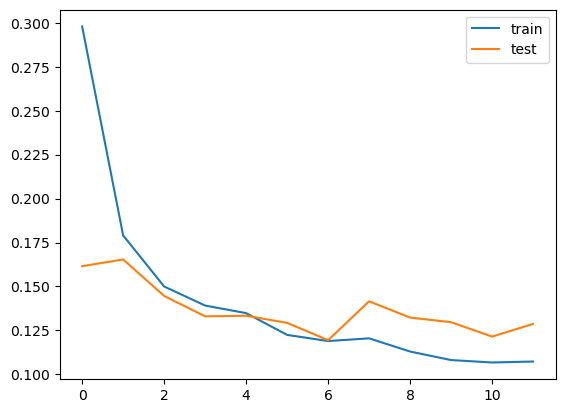

In [16]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()